/var/folders/6c/14k_v0k117s9zhf_fzm_fvx40000gn/T/ipykernel_8943/4293728324.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


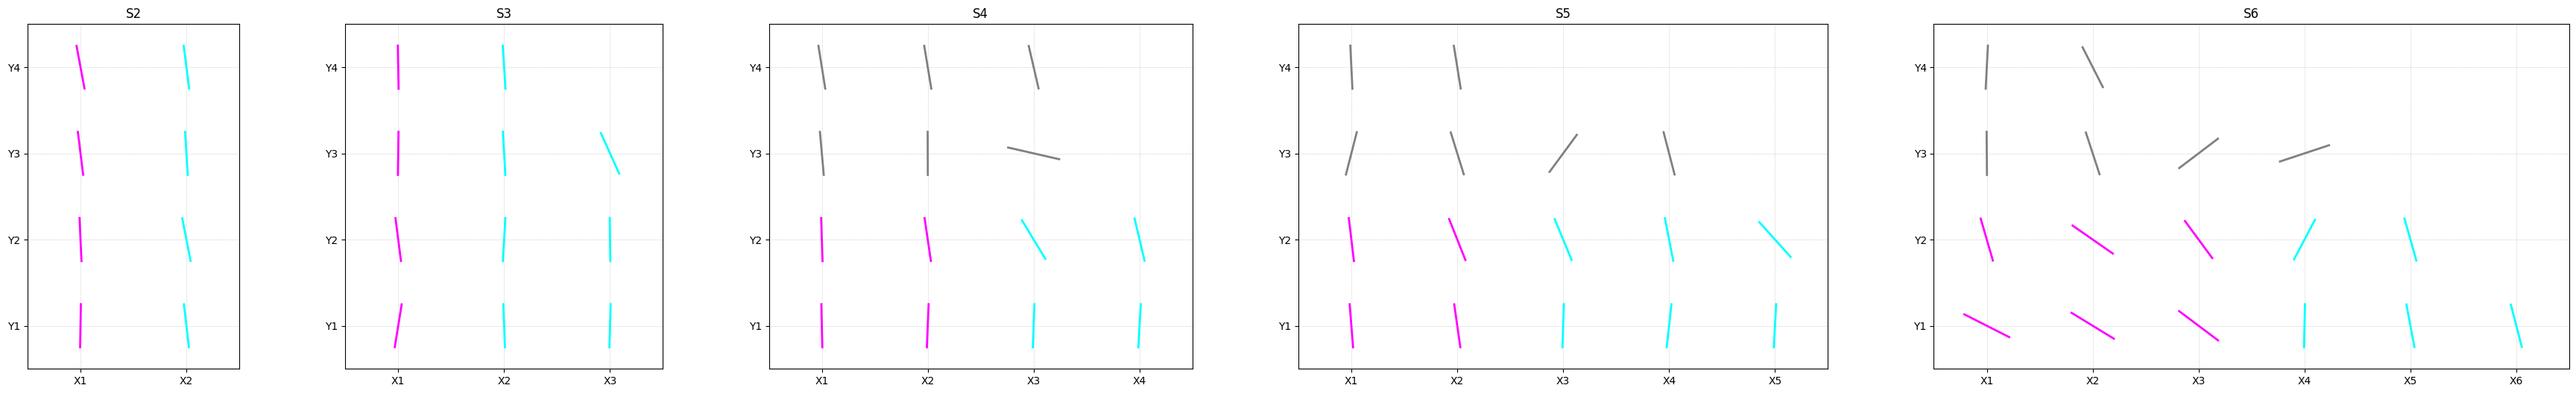

Saved: stages_variable_width_correctY_custom_colors.png


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- config ---
EXCEL_PATH = 'data_redone_after_reordering_and_verification_layers.xlsx'
OUTPUT_PATH = 'stages_variable_width_correctY_custom_colors.png'
dpi = 300
width_per_x = 2.2
fig_height = 6

# --- load a sheet with SXY_group and Degrees ---
xls = pd.ExcelFile(EXCEL_PATH)
df = None
for sh in xls.sheet_names:
    t = pd.read_excel(EXCEL_PATH, sheet_name=sh)
    cols = [c.lower() for c in t.columns]
    if 'sxy_group' in cols and 'degrees' in cols:
        df = t.copy()
        break
if df is None:
    df = pd.read_excel(EXCEL_PATH)

# --- normalize group labels ---
df['SXY_group'] = df['SXY_group'].astype(str).str.replace(r'G(\d+)', r'X\1', regex=True)

# --- parse stage, X, Y ---
df['Stage'] = df['SXY_group'].str.extract(r'(S\d)')[0]
df = df[df['Stage'].notna()].copy()
df['X_num'] = df['SXY_group'].str.extract(r'X(\d+)').astype(float)
df['Y_num'] = df['SXY_group'].str.extract(r'Y(\d+)').astype(float)

# --- compute mean Degrees per SXY group ---
grp = (df.groupby(['Stage', 'SXY_group', 'X_num', 'Y_num'], as_index=False)['Degrees']
         .mean())

# --- order stages ---
stages = sorted(grp['Stage'].unique(), key=lambda s: int(s[1:]))
x_counts = [int(grp[grp['Stage'] == s]['X_num'].nunique()) or 1 for s in stages]
total_width = sum(c * width_per_x for c in x_counts)

# --- custom color rule function ---
def get_color(stage, x, y):
    """Return color based on stage and X/Y rules."""
    if stage == 'S2':
        if x == 1: return 'magenta'
        if x == 2: return 'cyan'
    elif stage == 'S3':
        if x == 1: return 'magenta'
        if x in (2, 3): return 'cyan'
    elif stage == 'S4':
        if y in (1, 2):
            if x in (1, 2): return 'magenta'
            if x in (3, 4): return 'cyan'
        if y in (3, 4) and x in (1, 2, 3, 4): return 'gray'
    elif stage == 'S5':
        if y in (1, 2):
            if x in (1, 2): return 'magenta'
            if x in (3, 4, 5): return 'cyan'
        if y in (3, 4) and x in (1, 2, 3, 4, 5): return 'gray'
    elif stage == 'S6':
        if y in (1, 2):
            if x in (1, 2, 3): return 'magenta'
            if x in (4, 5, 6): return 'cyan'
        if y in (3, 4) and x in (1, 2, 3, 4, 5, 6): return 'gray'
    return 'black'  # fallback

# --- draw function ---
def draw_stage(ax, stage_df, stage_label):
    xs = sorted(stage_df['X_num'].dropna().unique())
    ys = sorted(stage_df['Y_num'].dropna().unique())
    if not xs or not ys:
        ax.set_visible(False)
        return

    line_length = 0.5
    for _, row in stage_df.iterrows():
        ang = np.deg2rad(row['Degrees'])
        dx = np.cos(ang) * line_length / 2.0
        dy = np.sin(ang) * line_length / 2.0
        x, y = row['X_num'], row['Y_num']
        color = get_color(stage_label, int(x), int(y))
        ax.plot([x - dx, x + dx], [y - dy, y + dy], linewidth=2, color=color)

    ax.set_xticks(xs)
    ax.set_xticklabels([f"X{int(v)}" for v in xs])
    ax.set_yticks(ys)
    ax.set_yticklabels([f"Y{int(v)}" for v in ys])
    ax.set_xlim(min(xs) - 0.5, max(xs) + 0.5)
    ax.set_ylim(min(ys) - 0.5, max(ys) + 0.5)
    ax.set_title(stage_label)
    ax.grid(which='both', axis='both', linestyle=':', linewidth=0.5)

# --- build figure ---
fig = plt.figure(figsize=(total_width, fig_height))
gs = GridSpec(1, len(stages), figure=fig, width_ratios=x_counts, wspace=0.25)

for i, s in enumerate(stages):
    ax = fig.add_subplot(gs[0, i])
    stage_df = grp[grp['Stage'] == s]
    draw_stage(ax, stage_df, s)

plt.tight_layout()
plt.savefig(OUTPUT_PATH, dpi=dpi)
plt.show()

print(f"Saved: {OUTPUT_PATH}")
